In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.attn_kq import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


In [13]:
for (m, n) in [(20, 40), (40, 40), (50, 50)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-2 * lamb_max**2, 1e-4)

        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=mu_reg,
            stopping=True, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED


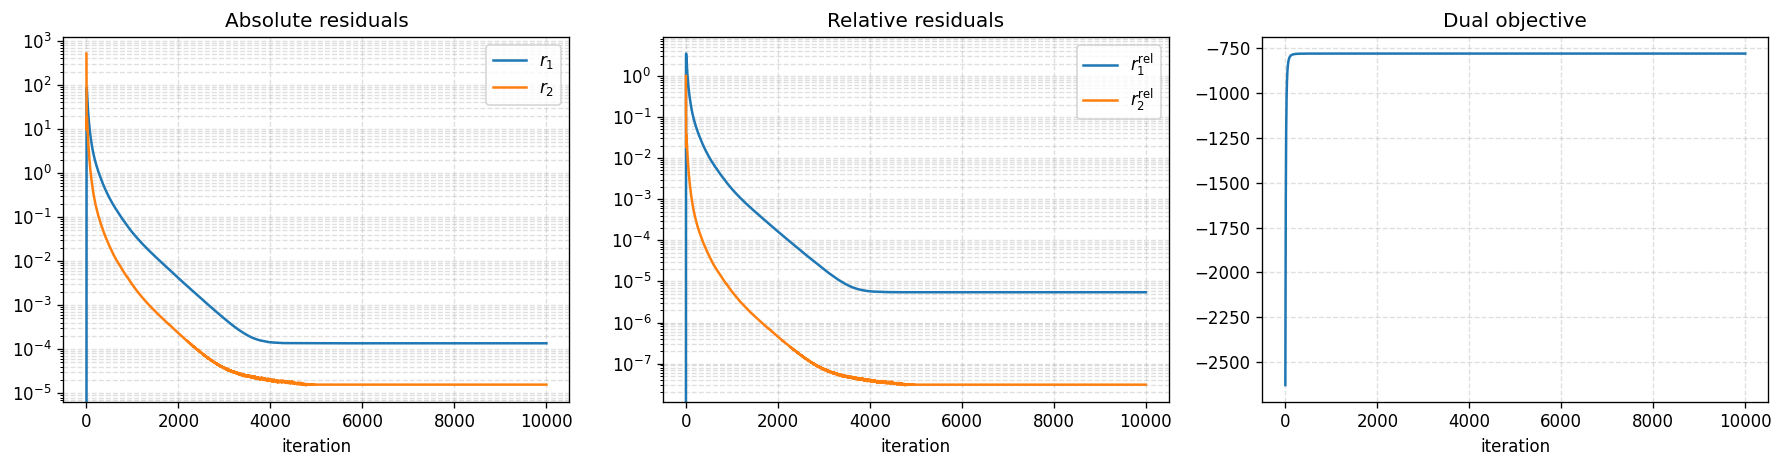

In [14]:
plot_residuals(residuals)

In [15]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
    print(f"{dual_res['res']=}")
    nA = torch.linalg.norm(A, ord="fro").item()
    nB = torch.linalg.norm(B, ord="fro").item()
    lamb_max = (nA * nA + nB * nB) ** 0.5
    mu_reg = max(1e-4 * lamb_max**2, 1e-4)

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
            max_iter=7000, eps_abs=1e-8, eps_rel=1e-8, mu=mu_reg,
            stopping=True,
            h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
    
    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


dual_res['res']=5.759924095282555e-06


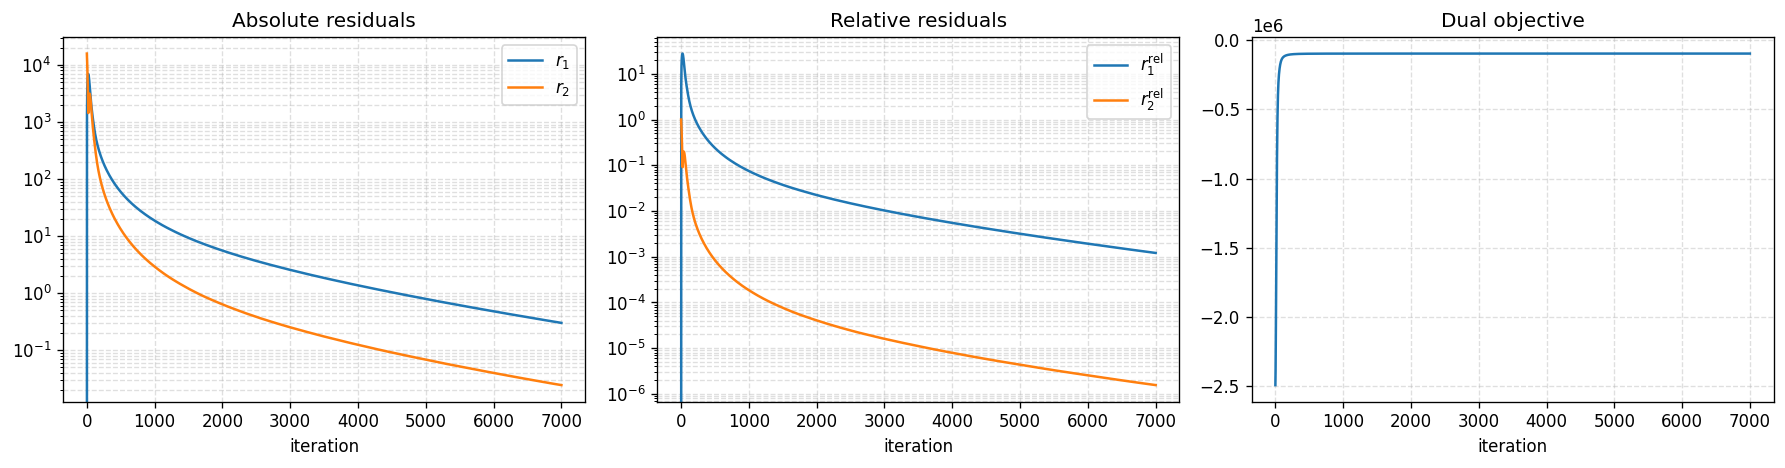

In [16]:
plot_residuals(residuals)

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## Diagonally Preconditioned PDHG

In [ ]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5

        # Torch tensors
        A = torch.from_numpy(A_np).to(torch.float32).to(device)
        B = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        nA = torch.linalg.norm(A, ord="fro").item()
        nB = torch.linalg.norm(B, ord="fro").item()
        lamb_max = (nA * nA + nB * nB) ** 0.5
        mu_reg = max(1e-2 * lamb_max**2, 1e-4)

        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=mu_reg,
            stopping=True, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=True, equilibration=False, reflected_halpern=False, enable_restart=False)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED


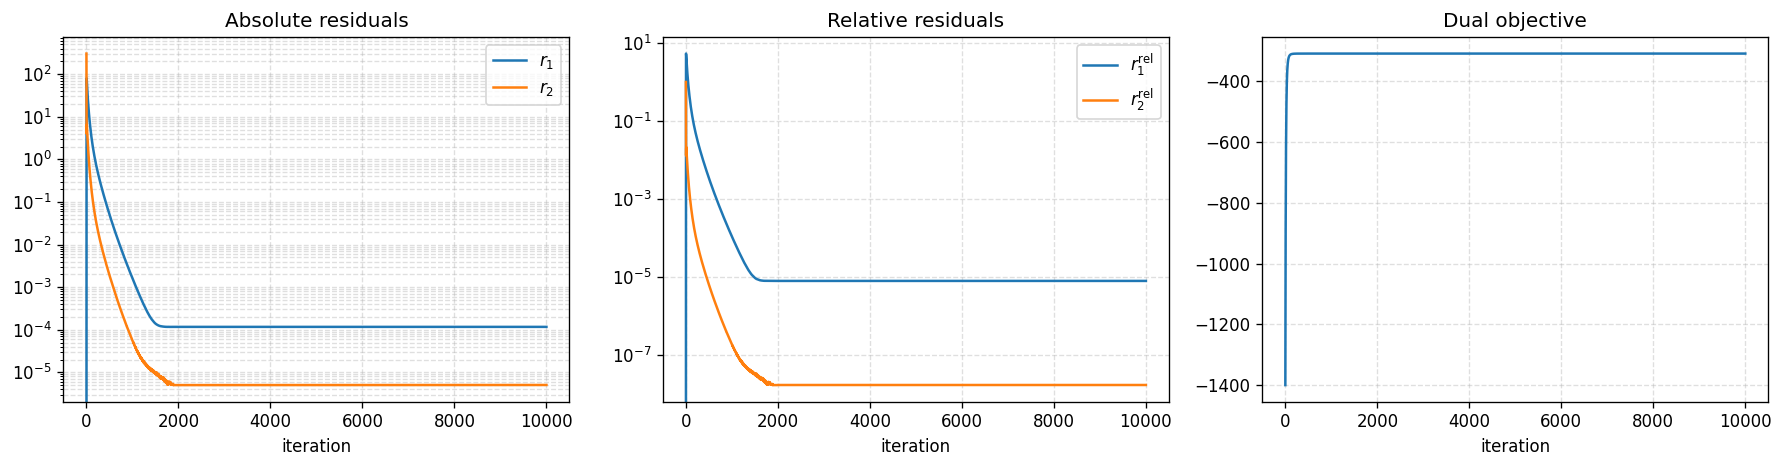

In [ ]:
plot_residuals(residuals)